# Air Quality Data for Allegheny County
Pittsburgh has an industrious industrial history; a steel town at heart, the town has had a recent influx of new tech and business, and is touted constantly as one of "the most livable cities".

The ghosts of the past still linger, however. In part due to the topography, and to the remaining industrial sites surrounding the city, Pittsburgh (and Allegheny County) suffers from incredibly poor air quality to this day. In an attempt to better understand the 
* What are the most common particulates found in Allegheny County?
* Is there any correlation between the day of the week and the AQI? 
* Is there a correlation between the hour of the day and the AQI?
* Is there a better part of the city to live in (NE, NW, SE, SW)?

#### Resources:
* https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1
* https://www.ethanrosenthal.com/2018/01/28/time-series-for-scikit-learn-people-part1/

## Import the necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import folium
sns.set(rc={'figure.figsize':(16,6)})
sns.set_style("white")

### Reading in the data

In [2]:

df = pd.read_csv('allegheny_county_air_quality.csv')
df.head(10)

/home/tim/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,site,datetime,bcstat,bcstat_txt,black_carbon,black_carbon_txt,bp,bp_txt,co,co_txt,...,sonicws,sonicws_txt,uvpm,uvpm_txt,rainfall,rainfall_txt,solarrad,solarrad_txt,uv_rad,uv_rad_txt
0,Avalon,2016-01-30T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Avalon,2016-01-15T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Avalon,2016-01-15T01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Avalon,2016-01-15T02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Avalon,2016-01-15T03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Avalon,2016-01-15T04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Avalon,2016-01-15T05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Avalon,2016-01-15T06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Avalon,2016-01-15T07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Avalon,2016-01-15T08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Removing Comments

In [3]:
def drop_txt(df):
    comment_columns = []
    for c in df.columns:
        if 'txt' in c:
            comment_columns.append(c)
    df = df.drop(columns=comment_columns)
    return df
df = drop_txt(df)
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642076 entries, 0 to 642075
Data columns (total 37 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   site          642076 non-null  object 
 1   datetime      642076 non-null  object 
 2   bcstat        52913 non-null   float64
 3   black_carbon  9902 non-null    float64
 4   bp            143055 non-null  float64
 5   co            136079 non-null  float64
 6   h2s           90269 non-null   float64
 7   int_t         431258 non-null  float64
 8   no            139582 non-null  float64
 9   no2           95570 non-null   float64
 10  nox           96045 non-null   float64
 11  noy           44086 non-null   float64
 12  noydif        43779 non-null   float64
 13  out_rh        100167 non-null  float64
 14  out_t         336982 non-null  float64
 15  ozone         133238 non-null  float64
 16  ozone2        35251 non-null   float64
 17  per_f         138579 non-null  float64
 18  per_

### Replacing NaN Values


In [4]:
for c in df.columns:
    if c not in ['site', 'datetime']:
        df[c].fillna(0)

### What _are_ these things?
Even with the `txt` columns gone, the column names are not intuitive in any way. At some point in my education I think I miss what an `rwd` was, or a `per_f`, and only the vaguest of highschool checmistry is ringing a bell with ` h2s`. 

Luckily, there is a data dictionary on the Allegheny county air quality site, so lets aggregate that with the remaining column names.

## Sensor Locations
Allegheny County provides the sensor locations where measurements are recorded; since the nature of this data is geo-located, it makes sense to aggregate the sensor latitude and longitude into the dataset.

In [5]:
locations = pd.read_csv('sensor_locations.csv')
locations.head()

,site_name,description,air_now_mnemonic,address,latitude,longitude,enabled
0,Harrison Township,Harrison Township Ozone and NO/NOx Site,HT1,Highlands Senior High School - 1500 Pacific Av...,40.613864,-79.729569,t
1,South Fayette,South Fayette Ozone and SO2 Site,SF1,South Fayette Elementary School - 3640 Old Oak...,40.375647,-80.169931,t
2,Lawrenceville,"Lawrenceville Ozone, and Met Site",LV1,Allegheny County Health Department - 301 39th ...,40.465433,-79.960742,t
3,Liberty,Liberty Borough South Allegheny High School Site,NaN,South Allegheny High School - 2743 Washington ...,40.323856,-79.868064,t
4,West Allegheny,West Allegheny H2S Site,NaN,NaN,40.444747,-80.267303,f


In [6]:
locations = locations[['site_name', 'latitude', 'longitude']]
locations.rename(columns={'site_name':'site'}, inplace=True)
df = pd.merge(df, locations, on='site')
df.head()

,site,datetime,bcstat,black_carbon,bp,co,h2s,int_t,no,no2,...,sigtheta,so2,sonicwd,sonicws,uvpm,rainfall,solarrad,uv_rad,latitude,longitude
0,Avalon,2016-01-30T00:00:00,NaN,NaN,NaN,NaN,NaN,23.1,NaN,NaN,...,34.7,0.0,140.0,2.2,NaN,NaN,NaN,NaN,40.499789,-80.071347
1,Avalon,2016-01-15T00:00:00,NaN,NaN,NaN,NaN,0.0,25.7,NaN,NaN,...,27.0,0.0,109.0,1.9,NaN,NaN,NaN,NaN,40.499789,-80.071347
2,Avalon,2016-01-15T01:00:00,NaN,NaN,NaN,NaN,0.0,25.8,NaN,NaN,...,16.5,0.0,81.0,2.5,NaN,NaN,NaN,NaN,40.499789,-80.071347
3,Avalon,2016-01-15T02:00:00,NaN,NaN,NaN,NaN,0.0,25.6,NaN,NaN,...,46.8,0.0,102.0,1.9,NaN,NaN,NaN,NaN,40.499789,-80.071347
4,Avalon,2016-01-15T03:00:00,NaN,NaN,NaN,NaN,0.0,25.6,NaN,NaN,...,12.4,0.0,77.0,2.3,NaN,NaN,NaN,NaN,40.499789,-80.071347


## Handling Datetime
The `datetime` object is incredbily useful; heck it's a date _and_ a time. Unfortunately, looking at something like `2016-01-30T00:00:00` isn't very intuitive for humans or computers, and does say much about the condition of things on Mondays, or the month of August, for example. Luckily Pandas provides the `datetime` library functionality native to Python, so we can extract some valuable information from a datetime entry, such as year, month, day, week number, etc etc. We can break out these categorizations and ditch the useful but difficult to use datetime format to glean a little more insight into the nature of air quality.

In [7]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month_name()
df['week'] = df['datetime'].dt.isocalendar().week
df['weekday'] = df['datetime'].dt.day_name()
df['hour'] = df['datetime'].dt.hour
df.drop(labels='datetime', axis=1, inplace=True)

## Isolating the Particulates

In [8]:
particulates = df.drop(['site', 'int_t', 'out_t', 'sonicwd', 'sonicws', 'sigtheta',
                        'out_rh', 'latitude', 'longitude', 'weekday', 'month',
                        'hour', 'per_f', 'noydif',
                        'bp', 'out_rh', 'pm10_fl', 'rwd', 'rws', 'bcstat',
                        'per_f2', 'uvpm', 'rainfall', 'uv_rad', 'solarrad',
                        'pm25_fl', 'year', 'week', 'date'], axis=1)

In [9]:
particulates.count().sort_values(ascending=False)

so2             241030
pm10            183222
ozone           133238
no              130453
co              126853
pm25t           118723
h2s              90269
nox              86808
no2              86441
pm10b            81770
pm25             69884
noy              44086
noydif           43779
pm25b            36589
ozone2           35251
pm25(2)          27254
black_carbon      9902
dtype: int64

### Summing the particulate counts

In [10]:
df['particulate_sum'] = df[particulates.columns].sum(axis=1)
df['particulate_sum'] = df[particulates.columns].count(axis=1)

## The best time to be outside
There's a lot of data from the last 5 years, including data from 2021. Since this data is incomplete by nature, to avoid bias in the results we're going to drop 2021 from the data collected.

In [11]:
ts_aqi = df[df['year'] != 2021]

We'll start by visualizing the air quality (based on the PM25 standard) with a series of bar graphs to get a better understanding of how the AQI changes over time.

### AQI by Year

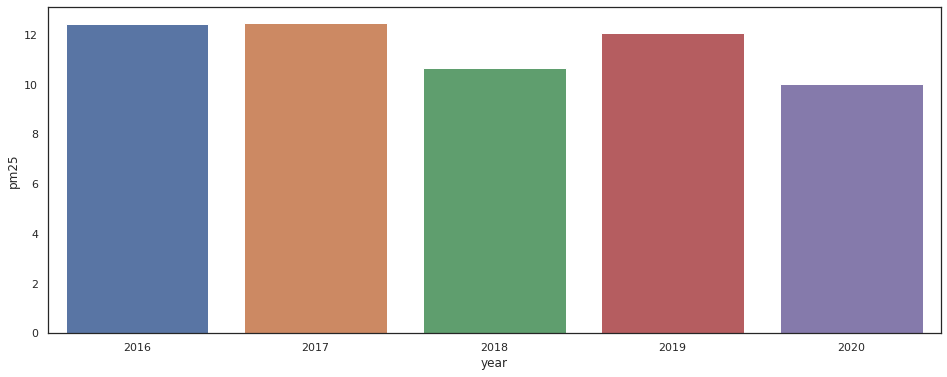

In [12]:
sns.barplot(data=ts_aqi.groupby('year').mean().reset_index(), x='year', y='pm25');

### AQI by Month

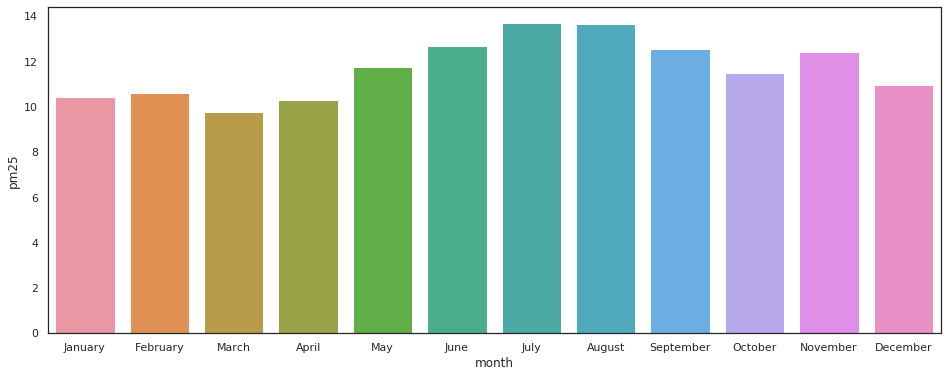

In [13]:
sns.barplot(data=ts_aqi.groupby('month').mean().reset_index(), x='month', y='pm25', order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December' ]);

### AQI by Week

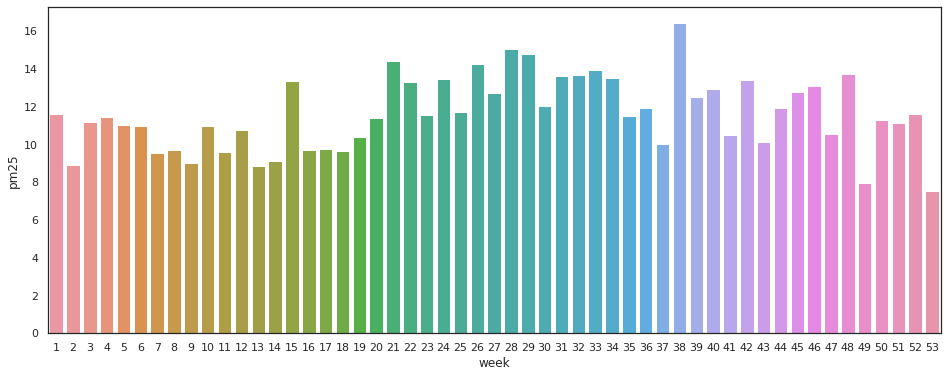

In [14]:
sns.barplot(data=ts_aqi.groupby('week').mean().reset_index(), x='week', y='pm25');

### AQI by Week Day

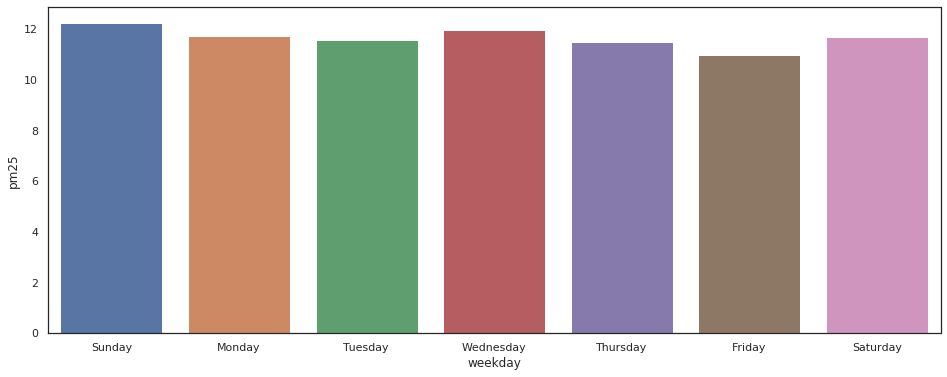

In [15]:
sns.barplot(data=ts_aqi.groupby('weekday').mean().reset_index(), x='weekday', y='pm25', order=["Sunday", "Monday", 
                                                       "Tuesday", "Wednesday",
                                                       "Thursday", "Friday",
                                                       "Saturday"]
);

### Hourly AQI

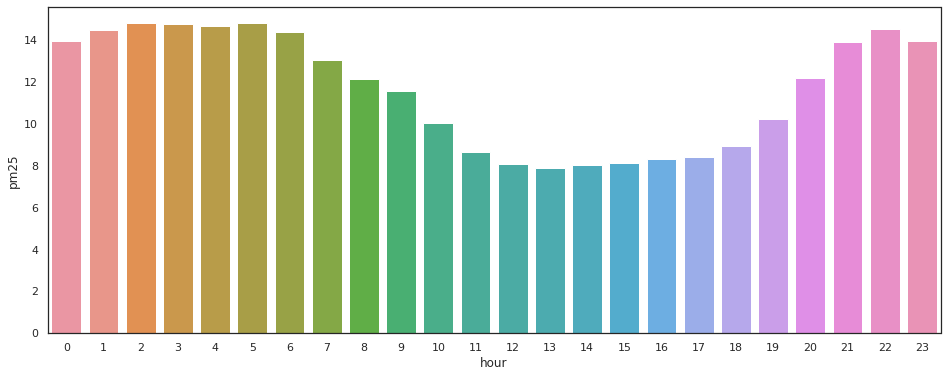

In [25]:
sns.barplot(data=ts_aqi.groupby('hour').mean().reset_index(), x='hour', y='pm25');

## Air Quality by Area
Since we have the locations of the sensors, we can categorize the data based on their location relative to the city center. This should give some indication of the best areas in Allegheny County for air quality

In [17]:
def quadrant(df, city_center=[40.441585415615734, -80.00550314688637]):
    """Returns the location of the sensor relative to the city center as
    dataframe columns of Northing, Easting, and the Quadrant of the city.
    """
    df['northing'] = np.where((df.latitude > 40.441013359221145),'N', 'S')
    df['easting'] = np.where((df.longitude < -79.99987496364024),'W', 'E')
    df['quadrant'] = df['northing'] + df['easting']
#     df.drop(['northing','easting'], axis=1, inplace=True)
    return df
    

In [18]:
df = quadrant(df)
df.sample(10)

,site,bcstat,black_carbon,bp,co,h2s,int_t,no,no2,nox,...,date,year,month,week,weekday,hour,particulate_sum,northing,easting,quadrant
443432,Liberty 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2018-05-25,2018,May,21,Friday,5,4,S,E,SE
555876,Parkway East,0.0,949.0,729.4,0.7172,NaN,22.3,1.3,12.4,13.8,...,2020-09-07,2020,September,37,Monday,20,6,S,E,SE
181721,Flag Plaza,NaN,NaN,NaN,NaN,NaN,23.4,NaN,NaN,NaN,...,2020-10-30,2020,October,44,Friday,1,1,N,E,NE
510593,North Braddock,NaN,NaN,738.0,NaN,NaN,21.9,NaN,NaN,NaN,...,2020-06-25,2020,June,26,Thursday,1,2,S,E,SE
51586,Lincoln,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2016-06-02,2016,June,22,Thursday,7,2,S,E,SE
431566,Liberty 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2016-10-23,2016,October,42,Sunday,15,3,S,E,SE
407419,Liberty,NaN,NaN,NaN,NaN,0.001,24.9,NaN,NaN,NaN,...,2019-07-28,2019,July,30,Sunday,19,2,S,E,SE
527198,Parkway East,0.0,NaN,721.4,0.2301,NaN,23.8,0.5,7.0,7.5,...,2018-03-06,2018,March,10,Tuesday,22,5,S,E,SE
75930,Lincoln,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-04-06,2019,April,14,Saturday,2,2,S,E,SE
395549,Liberty,NaN,NaN,NaN,NaN,0.000,23.7,NaN,NaN,NaN,...,2018-04-24,2018,April,17,Tuesday,18,2,S,E,SE


In [19]:
df.quadrant.value_counts()

SE    342744
NE    189888
NW     47856
SW     47344
Name: quadrant, dtype: int64

In [20]:
aq_quadrants = df.groupby('quadrant').mean().reset_index()
aq_quadrants.head()

,quadrant,bcstat,black_carbon,bp,co,h2s,int_t,no,no2,nox,...,uvpm,rainfall,solarrad,uv_rad,latitude,longitude,year,week,hour,particulate_sum
0,NE,NaN,NaN,739.440142,14.908231,NaN,22.507860,2.73279,5.688372,7.629002,...,NaN,0.004794,166.035445,6.60197,40.496892,-79.910567,2018.269464,25.588505,11.498547,3.354656
1,NW,NaN,NaN,NaN,NaN,0.000127,21.815427,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,40.499789,-80.071347,2018.251254,25.458375,11.500000,2.582644
2,SE,0.417876,760.983741,735.170761,0.478037,0.002125,23.098628,5.42525,10.061331,15.474184,...,1099.164126,NaN,NaN,NaN,40.347862,-79.870017,2018.134094,26.144615,11.499195,1.996443
3,SW,NaN,NaN,NaN,NaN,NaN,23.277024,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,40.375647,-80.169931,2018.275600,25.63235,11.498057,2.126542


In [21]:
aq_quadrants = aq_quadrants.dropna(axis=1, how='any')
aq_quadrants.head()

,quadrant,int_t,out_t,sigtheta,so2,sonicwd,sonicws,latitude,longitude,year,week,hour,particulate_sum
0,NE,22.507860,12.686749,27.445502,0.000618,198.368370,5.092931,40.496892,-79.910567,2018.269464,25.588505,11.498547,3.354656
1,NW,21.815427,11.770553,36.773534,0.000168,201.325651,4.067865,40.499789,-80.071347,2018.251254,25.458375,11.500000,2.582644
2,SE,23.098628,12.527087,33.861487,0.002368,196.449616,4.217234,40.347862,-79.870017,2018.134094,26.144615,11.499195,1.996443
3,SW,23.277024,11.525160,21.993837,0.000538,209.294488,5.728762,40.375647,-80.169931,2018.275600,25.63235,11.498057,2.126542


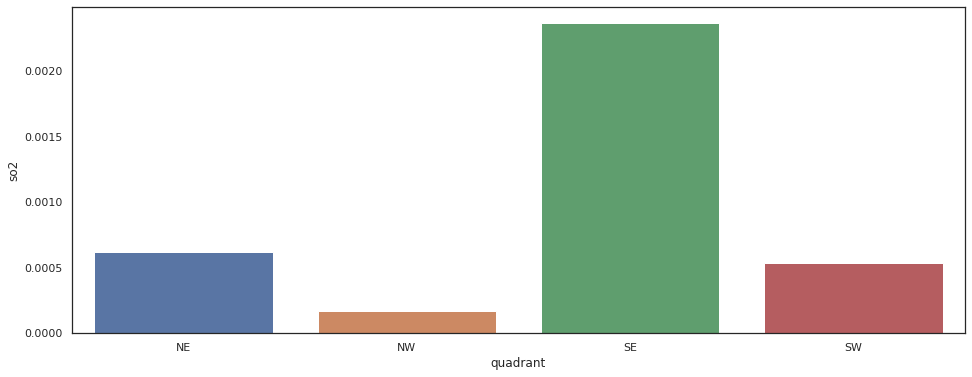

In [22]:
sns.barplot(data=aq_quadrants, x='quadrant', y='so2');

## Mapping Sensor Locations with Folium
As a lover of maps, Folium might be one of my favorite Python libraries; clean beautiful maps (with no JS!).

In [26]:
m = folium.Map(location=[40.441585415615734, -80.00550314688637], tiles="Stamen Toner")
for i in range(locations.shape[0]):
    sensor = locations.iloc[i]
    if sensor.latitude >0:
        folium.Marker([sensor.latitude, sensor.longitude], popup=sensor.site).add_to(m)
m